In [1]:
using DataFrames, CSV, MLJ, MLJLinearModels, DecisionTree, VegaLite

In [39]:
# Import training dataset
lichen_training = CSV.read("C:/Users/jnovoa/Downloads/lichen_training.csv", DataFrame) |>
x -> select(x, "Total.lichen", "basal_area", "PL", "mean_Long") |>
x -> rename(x, ["biomass", "basalarea", "pl", "lon"]) |>
x -> coerce(x, Count => Continuous);

In [40]:
lichen_training[!, "biomass_log"] = log.(lichen_training[!, :biomass])
select!(lichen_training, Not(:biomass));

In [41]:
schema(lichen_training)

┌─────────────┬─────────┬────────────┐
│ _.names     │ _.types │ _.scitypes │
├─────────────┼─────────┼────────────┤
│ basalarea   │ Float64 │ Continuous │
│ pl          │ Float64 │ Continuous │
│ lon         │ Float64 │ Continuous │
│ biomass_log │ Float64 │ Continuous │
└─────────────┴─────────┴────────────┘
_.nrows = 78


In [42]:
# Split predictors (X) and response variable (y)
y, X = unpack(lichen_training, ==(:biomass_log), _ -> true);

In [43]:
# Load a LinearRegressor using the GLM package
LinearRegressor = @load LinearRegressor pkg=MLJLinearModels

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jnovoa\.julia\packages\MLJModels\GKDnU\src\loading.jl:168


MLJLinearModels.LinearRegressor

In [44]:
# Instantiate a linear regressor model using a pipeline
LinearRegressorPipe = @pipeline(Standardizer(), LinearRegressor())

Pipeline266(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    linear_regressor = LinearRegressor(
            fit_intercept = true,
            solver = nothing))

In [45]:
# Create an MLJ machine (model + data)
LinearModel = machine(LinearRegressor(), X, y)

Machine{LinearRegressor,…} trained 0 times; caches data
  args: 
    1:	Source @948 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @296 ⏎ `AbstractVector{Continuous}`


In [46]:
# Split into train/test datasets
train, test = partition(eachindex(y), 0.8, shuffle=true, rng=1010)

([66, 63, 5, 22, 49, 15, 47, 64, 35, 12  …  61, 57, 21, 14, 78, 40, 27, 74, 68, 18], [2, 53, 50, 39, 38, 46, 77, 29, 69, 7, 60, 59, 17, 30, 43, 51])

In [47]:
# Fit the machine
fit!(LinearModel, rows=train)

┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\jnovoa\.julia\packages\MLJBase\QXObv\src\machines.jl:403


Machine{LinearRegressor,…} trained 1 time; caches data
  args: 
    1:	Source @948 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @296 ⏎ `AbstractVector{Continuous}`


In [48]:
# Check trained parameters
fp = fitted_params(LinearModel)

(coefs = [:basalarea => -0.07331667711224661, :pl => 0.023510643528123275, :lon => -0.9440052662173859],
 intercept = -113.12285731640532,)

In [49]:
# Make predictions on test
y_test_pred = predict(LinearModel, rows=test)
y_train_pred = predict(LinearModel, rows=train)

62-element Vector{Float64}:
 4.954982896576951
 2.8421040027484565
 2.8712542999000874
 6.925332395121941
 4.595659103169396
 5.475291673027385
 2.7065777748370436
 7.59689677346168
 4.135787959144196
 3.8573355221033268
 ⋮
 6.273143597555077
 5.734281348351189
 5.363681997106667
 5.6472316725152325
 4.281840860041882
 6.817216183985053
 5.310255118366854
 6.101027205398296
 5.129597351228341

In [50]:
describe(y_test_pred)

Summary Stats:
Length:         16
Missing Count:  0
Mean:           5.058194
Minimum:        2.006203
1st Quartile:   4.146763
Median:         5.290936
3rd Quartile:   6.274129
Maximum:        6.607970
Type:           Float64


In [51]:
rms(y_test_pred, y[test])

3.075046956584085

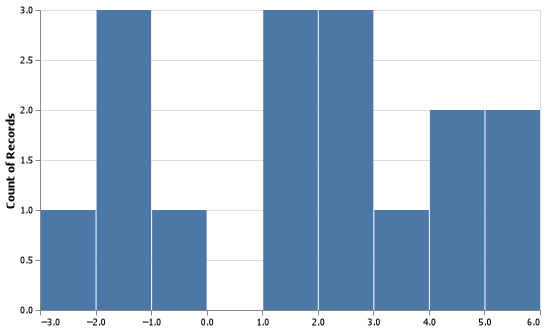

In [52]:
residuals = y_test_pred - y[test]
@vlplot(
    width=500,
    height=300,
    :bar, x={residuals, bin=true}, y="count()")

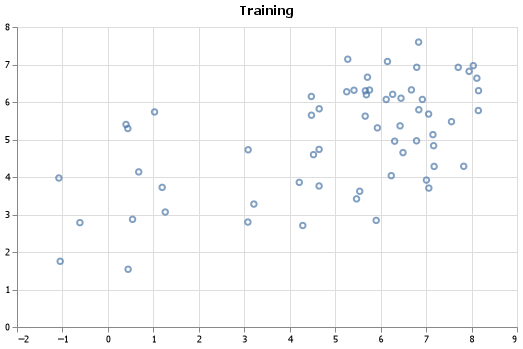

In [53]:
@vlplot(
    width=500,
    height=300,
    :point,
    x=y[train],
    y=y_train_pred,
    title="Training"
)

# Predict on new dataset

In [55]:
# Import CSV to dataframe, select the same columns used for training
lichen = CSV.read("C:/Users/jnovoa/Downloads/predicted_biomass_Nov2021.csv", DataFrame) |>
x -> select(x, :BASAL_AREA, :PL, :LON) |>
x -> rename(x, ["basalarea", "pl", "lon"]);

In [56]:
biomass = exp.(predict(LinearModel, lichen))

213821-element Vector{Float64}:
  235.63390233319512
  103.22982469348803
  152.2533379781093
  396.14168888031355
 1018.2662663615342
  119.71647081349874
  119.19309382318978
  149.6752131973856
  110.72346452562448
  223.91992448012823
    ⋮
  176.81836390056841
   25.123394661866676
  273.3574949476115
   56.31347371240417
   19.78893351598704
    8.37129315363364
   18.66901050631253
   88.83952874006599
  112.48843851512528

In [59]:
CSV.write("C:/Users/jnovoa/Downloads/predicted_biomass.csv", DataFrame(biomass=biomass))

"C:/Users/jnovoa/Downloads/predicted_biomass.csv"